# 1. Preparação dos Dados

## 📘 Imports e Configurações Iniciais

In [68]:
# Imports
import pandas as pd
import numpy as np
import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import ipywidgets as widgets
from IPython.display import display, clear_output


# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 📁 Leitura dos Arquivos

In [41]:

# Leitura dos arquivos CSV
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
categories = pd.read_csv('data/product_category_name_translation.csv')

# Organização dos DataFrames em dicionário
dataframes = {
    'orders': orders,
    'order_items': order_items,
    'geolocation': geolocation,
    'customers': customers,
    'payments': payments,
    'reviews': reviews,
    'products': products,
    'sellers': sellers,
    'categories': categories
}


## 🧽 Funções Auxiliares

In [42]:

def normalizar_nomes_colunas(dataframes):
    for nome, df in dataframes.items():
        df.columns = [unidecode.unidecode(col.lower().strip().replace(' ', '_')) for col in df.columns]
        dataframes[nome] = df

def normalizar_valores_categoricos(df, colunas):
    for col in colunas:
        df[col] = df[col].astype(str).str.strip().str.upper()

def detectar_colunas_datetime(df):
    colunas = []
    for col in df.columns:
        if any(x in col.lower() for x in ['date', 'time', 'timestamp']):
            if df[col].dtype == 'object':
                try:
                    pd.to_datetime(df[col])
                    colunas.append(col)
                except:
                    pass
    return colunas

def converter_colunas_datetime(df, colunas):
    for col in colunas:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df


## ⚙️ Preparação e Limpeza dos Dados

In [43]:

# Normalizar nomes das colunas
normalizar_nomes_colunas(dataframes)

# Normalizar valores categóricos
normalizar_valores_categoricos(dataframes['customers'], ['customer_state'])
normalizar_valores_categoricos(dataframes['sellers'], ['seller_state'])

# Verificação de nulos
for name, df in dataframes.items():
    print(f'\nNulos em: {name}')
    nulos = df.isnull().sum()
    print(nulos[nulos > 0] if not nulos.empty else "Nenhum")

# Verificação de duplicatas
for name, df in dataframes.items():
    print(f'{name}: {df.duplicated().sum()} duplicatas')

# Conversão de colunas datetime
for nome, df in dataframes.items():
    dt_cols = detectar_colunas_datetime(df)
    df = converter_colunas_datetime(df, dt_cols)
    dataframes[nome] = df

# Normalização numérica (price, freight)
scaler = MinMaxScaler()
dataframes['order_items'][['price', 'freight_value']] = scaler.fit_transform(
    dataframes['order_items'][['price', 'freight_value']]
)



Nulos em: orders
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

Nulos em: order_items
Series([], dtype: int64)

Nulos em: geolocation
Series([], dtype: int64)

Nulos em: customers
Series([], dtype: int64)

Nulos em: payments
Series([], dtype: int64)

Nulos em: reviews
review_comment_title      87656
review_comment_message    58247
dtype: int64

Nulos em: products
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Nulos em: sellers
Series([], dtype: int64)

Nulos em: categories
Series([], dtype: int64)
orders: 0 duplicatas
order_items: 0 duplicatas
geolocation: 261831 duplicatas
customers: 0 duplicatas
payments: 0 duplicatas
reviews: 0 duplicatas
products: 0 duplicatas
seller

## 🔗 Criação dos DataFrames Combinados

In [44]:
# Combinações úteis para análise
orders_customers = pd.merge(dataframes['orders'], dataframes['customers'], on='customer_id', how='inner')
orders_payments = pd.merge(dataframes['orders'], dataframes['payments'], on='order_id', how='left')
orders_reviews = pd.merge(dataframes['orders'], dataframes['reviews'], on='order_id', how='left')

products_translated = pd.merge(
    dataframes['products'],
    dataframes['categories'],
    on='product_category_name',
    how='left'
)
products_translated['product_category_name'] = products_translated['product_category_name_english']
products_translated.drop(columns=['product_category_name_english'], inplace=True)

items_full = pd.merge(dataframes['order_items'], products_translated, on='product_id', how='left')
items_full = pd.merge(items_full, dataframes['sellers'], on='seller_id', how='left')

orders_full = dataframes['orders'].copy()
orders_full = pd.merge(orders_full, dataframes['customers'], on='customer_id', how='left')
orders_full = pd.merge(orders_full, dataframes['order_items'], on='order_id', how='left')
orders_full = pd.merge(orders_full, products_translated, on='product_id', how='left')
orders_full = pd.merge(orders_full, dataframes['sellers'], on='seller_id', how='left')
orders_full = pd.merge(orders_full, dataframes['payments'], on='order_id', how='left')
orders_full = pd.merge(orders_full, dataframes['reviews'], on='order_id', how='left')


# 2. Análise Exploratória de Dados

### a) Volume de pedidos por mês

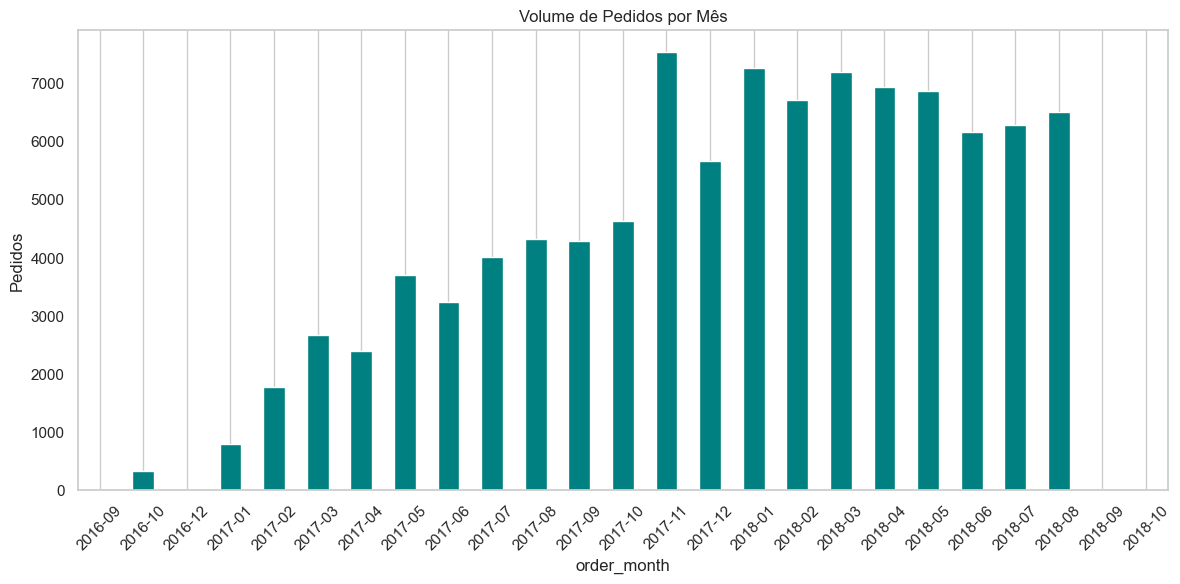

In [45]:

orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full['order_purchase_timestamp'])
orders_full['order_month'] = orders_full['order_purchase_timestamp'].dt.to_period('M')
pedidos_por_mes = orders_full.groupby('order_month')['order_id'].nunique()

pedidos_por_mes.plot(kind='bar', color='teal', figsize=(12,6))
plt.title('Volume de Pedidos por Mês')
plt.ylabel('Pedidos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Esse comportamento indica a presença de sazonalidade nas vendas, com um pico acentuado em novembro, possivelmente relacionado a eventos ou promoções específicas, seguido de uma queda em dezembro e posterior estabilização.

### b) Distribuição do tempo de entrega

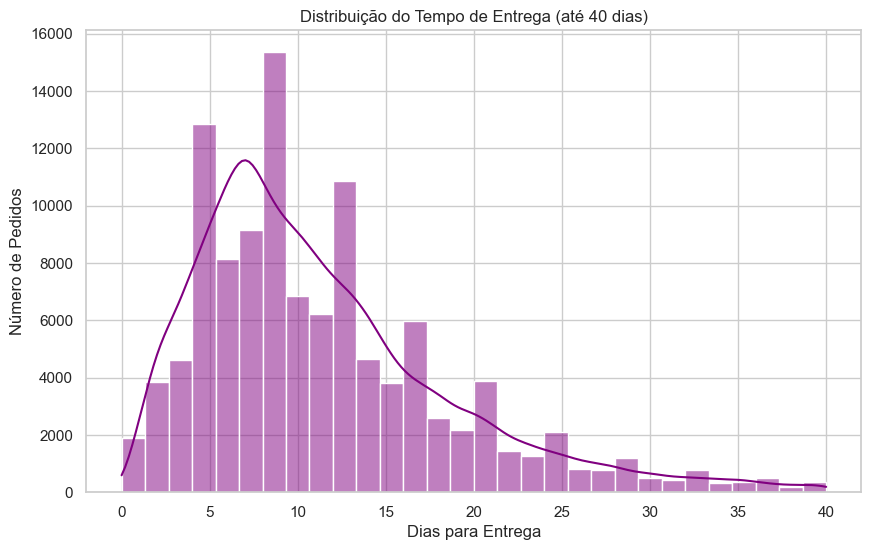

In [46]:
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date'])
orders_full['tempo_entrega'] = (orders_full['order_delivered_customer_date'] - orders_full['order_purchase_timestamp']).dt.days
tempo_entrega_clean = orders_full['tempo_entrega'].dropna()
tempo_entrega_clean = tempo_entrega_clean[tempo_entrega_clean <= 40]

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(tempo_entrega_clean, bins=30, kde=True, color='purple')
plt.title('Distribuição do Tempo de Entrega (até 40 dias)')
plt.xlabel('Dias para Entrega')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.show()

### A maioria dos pedidos foi entregue em até 13 dias, com destaque para três picos de frequência em 5, 9 e 12 dias. A curva de distribuição é assimétrica à direita, indicando que a maior parte das entregas ocorre em poucos dias, e apenas uma parcela menor demora mais. A concentração de entregas entre 5 e 12 dias sugere um padrão logístico relativamente eficiente, com poucos casos fora desse intervalo.

### c) Relação entre frete e distância

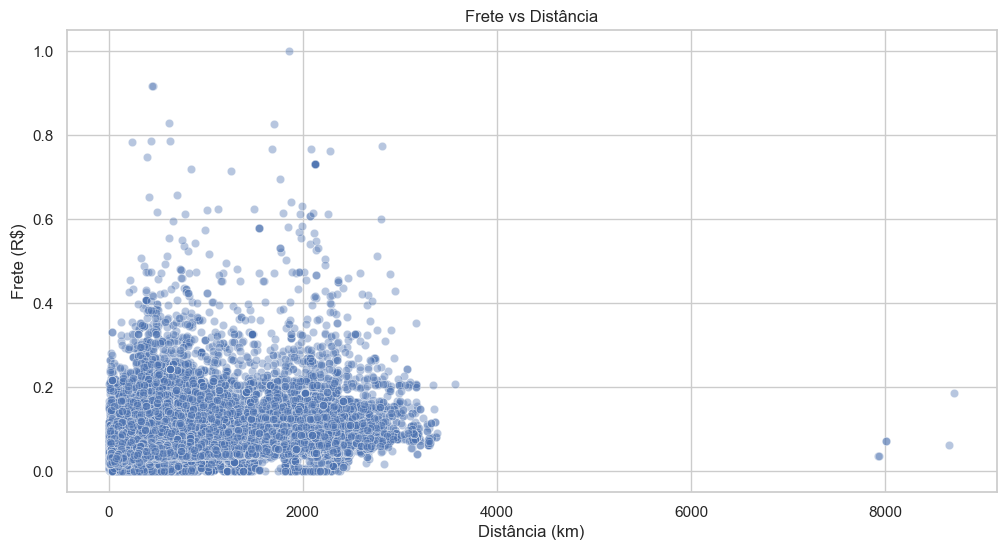

In [47]:
# Enriquecer geolocalização
geo = dataframes['geolocation'].drop_duplicates('geolocation_zip_code_prefix')
customers_geo = pd.merge(dataframes['customers'], geo, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers_geo = pd.merge(dataframes['sellers'], geo, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

# Renomear colunas geográficas
customers_geo = customers_geo.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})
sellers_geo = sellers_geo.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})

# Combinar com orders_full
orders_full = pd.merge(orders_full, customers_geo[['customer_id', 'customer_lat', 'customer_lng']], on='customer_id', how='left')
orders_full = pd.merge(orders_full, sellers_geo[['seller_id', 'seller_lat', 'seller_lng']], on='seller_id', how='left')

# Calcular distância
def calcular_distancia(row):
    try:
        return geodesic((row['seller_lat'], row['seller_lng']), (row['customer_lat'], row['customer_lng'])).km
    except:
        return None

orders_full['distancia_km'] = orders_full.apply(calcular_distancia, axis=1)

sns.scatterplot(data=orders_full, x='distancia_km', y='freight_value', alpha=0.4)
plt.title('Frete vs Distância')
plt.xlabel('Distância (km)')
plt.ylabel('Frete (R$)')
plt.grid(True)
plt.show()

### O gráfico mostra que a maioria dos pedidos está concentrada em distâncias até cerca de 2000 km, onde o valor do frete varia, mas em geral fica abaixo de 0,2 (normalizado). Há uma tendência de aumento do valor do frete conforme a distância aumenta, mas com bastante dispersão, indicando que outros fatores também influenciam o preço do frete. Acima de 2000 km, o número de pedidos diminui, e o valor do frete pode variar mais amplamente, ainda que geralmente mais alto.

### d) Categorias mais vendidas por faturamento

product_category_name
health_beauty            185.689633
watches_gifts            178.183339
bed_bath_table           152.586582
sports_leisure           145.631464
computers_accessories    134.434393
furniture_decor          107.315487
cool_stuff                93.859544
housewares                93.007916
auto                      87.482512
garden_tools              71.510363
Name: price, dtype: float64


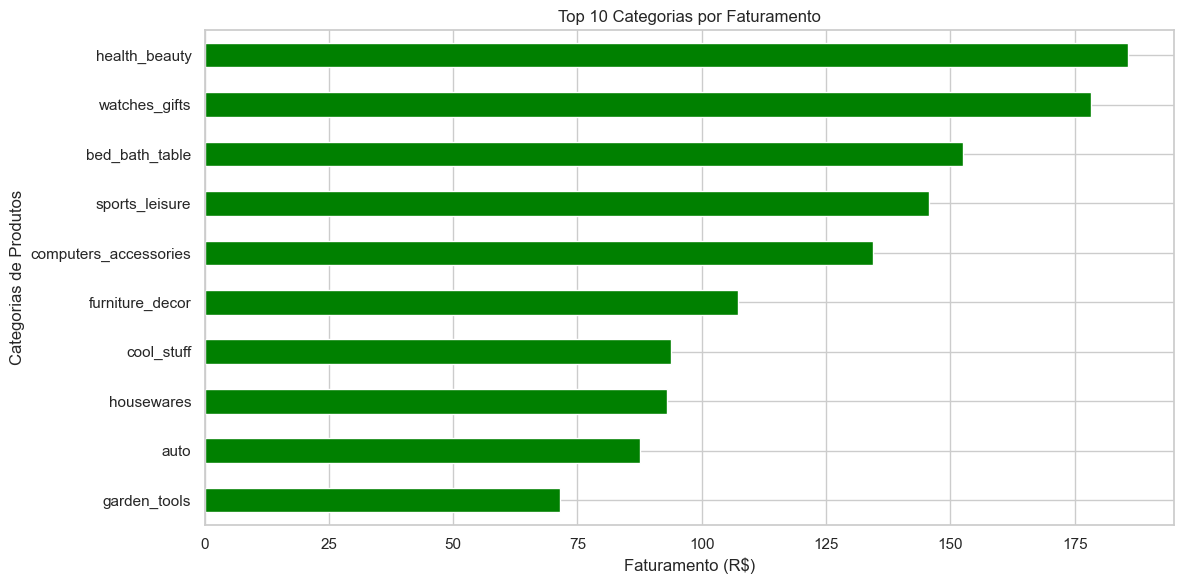

In [48]:
order_items_prod = pd.merge(dataframes['order_items'], products_translated, on='product_id', how='left')
faturamento_categoria = order_items_prod.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(10)
print(faturamento_categoria)

faturamento_categoria.plot(kind='barh', color='green')
plt.title('Top 10 Categorias por Faturamento')
plt.xlabel('Faturamento (R$)')
plt.ylabel('Categorias de Produtos')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### As categorias de produtos que mais geraram faturamento foram lideradas por health_beauty (R$ 185.690), seguida por watches_gifts (R$ 178.183) e bed_bath_table (R$ 152.587). Essas três representam os principais motores de receita, seguidas por sports_leisure e computers_accessories. O top 10 ainda inclui categorias como furniture_decor, cool_stuff, housewares, auto e garden_tools, que, embora com faturamento menor, são relevantes para o portfólio. Esse panorama destaca a importância dos produtos de saúde e beleza e artigos para presentes e casa no faturamento total.

### e) Estados com maior valor médio de pedido

                valor_total  num_pedidos  valor_medio
customer_state                                       
PB                17.040960          536     0.031793
AP                 1.990541           68     0.029273
AC                 2.361805           81     0.029158
AL                11.870453          413     0.028742
PA                26.436864          975     0.027115
RO                 6.816649          253     0.026943
TO                 7.328912          280     0.026175
PI                12.838054          495     0.025935
MT                23.099690          907     0.025468
RN                12.263661          485     0.025286


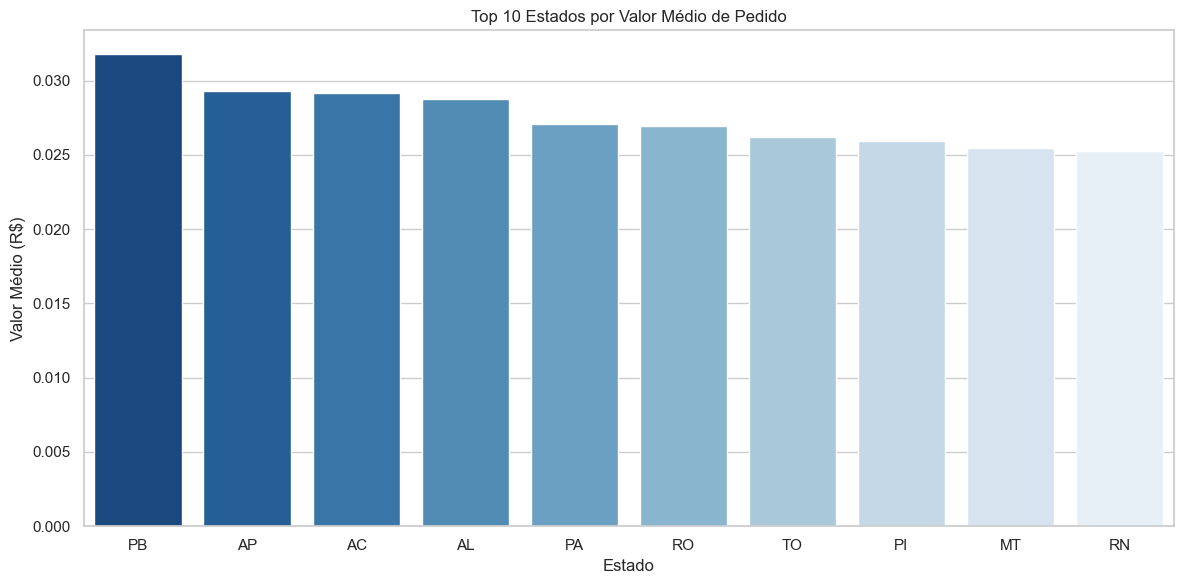

In [49]:
orders_customers = pd.merge(dataframes['orders'], dataframes['customers'], on='customer_id', how='left')
order_valores = pd.merge(orders_customers, dataframes['order_items'], on='order_id', how='left')

valor_estado = order_valores.groupby('customer_state').agg(
    valor_total=('price', 'sum'),
    num_pedidos=('order_id', 'nunique')
)
valor_estado['valor_medio'] = valor_estado['valor_total'] / valor_estado['num_pedidos']
valor_estado = valor_estado.sort_values('valor_medio', ascending=False).head(10)
print(valor_estado)

sns.barplot(x=valor_estado.index, y=valor_estado['valor_medio'], hue=valor_estado.index, palette='Blues_r', legend=False)
plt.title('Top 10 Estados por Valor Médio de Pedido')
plt.xlabel('Estado')
plt.ylabel('Valor Médio (R$)')
plt.tight_layout()
plt.show()


### Os estados com o maior valor médio de pedido, considerando os dados normalizados, são Paraíba (PB), Amapá (AP) e Acre (AC). Esses estados apresentam, proporcionalmente, os pedidos mais valiosos em média quando comparados aos demais. Isso indica que, embora possam não ser os que mais vendem em volume, os consumidores dessas regiões tendem a fazer pedidos de maior valor individual.

# 3. Solução de Problemas de Negócio

### 3.1 Análise de Retenção

In [75]:
# Contar o número de pedidos por cliente
pedidos_por_cliente = orders_full.groupby('customer_unique_id')['order_id'].nunique().reset_index()
pedidos_por_cliente.columns = ['customer_unique_id', 'qtd_pedidos']

# Identificar clientes recorrentes
clientes_recorrentes = pedidos_por_cliente[pedidos_por_cliente['qtd_pedidos'] > 1]
clientes_nao_recorrentes = pedidos_por_cliente[pedidos_por_cliente['qtd_pedidos'] == 1]

# Calcular total de clientes
total_clientes = pedidos_por_cliente.shape[0]
total_recorrentes = clientes_recorrentes.shape[0]

# Taxa de retenção
taxa_recorrencia = total_recorrentes / total_clientes

print(f"Total de clientes: {total_clientes}")
print(f"Clientes recorrentes (mais de 1 pedido): {total_recorrentes}")
print(f"Taxa de clientes recorrentes: {taxa_recorrencia:.2%}")


Total de clientes: 96096
Clientes recorrentes (mais de 1 pedido): 2997
Taxa de clientes recorrentes: 3.12%


### A taxa de clientes recorrentes no período analisado é baixa, indicando que a maioria realizou apenas uma compra. Isso sugere a necessidade de focar em estratégias de fidelização, como programas de incentivo e melhorias na experiência do cliente, para aumentar a recompra. Recomenda-se também investigar possíveis causas da baixa retenção e segmentar os clientes recorrentes para ações mais direcionadas.

## 3.2 Predição de Atraso

In [76]:
# Criar a variável alvo (target)
orders_full['atraso'] = orders_full['order_delivered_customer_date'] > orders_full['order_estimated_delivery_date']
orders_full['atraso'] = orders_full['atraso'].astype(int)  # 1 para atrasado, 0 para não atrasado

In [77]:
# Selecionar colunas para o modelo
features = ['tempo_entrega', 'order_item_id', 'freight_value', 'price', 'payment_installments', 'review_score']
df_model = orders_full[features + ['atraso']].dropna()


In [78]:
from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model['atraso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [79]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Distribuição das classes no dataset:
atraso
0    0.922861
1    0.077139
Name: proportion, dtype: float64
Acurácia: 0.9601253700156712
Matriz de Confusão:
 [[31431   385]
 [  989  1653]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     31816
           1       0.81      0.63      0.71      2642

    accuracy                           0.96     34458
   macro avg       0.89      0.81      0.84     34458
weighted avg       0.96      0.96      0.96     34458

AUC-ROC: 0.9526559035422644

Relatório com threshold customizado (0.3):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     31816
           1       0.70      0.74      0.72      2642

    accuracy                           0.96     34458
   macro avg       0.84      0.86      0.85     34458
weighted avg       0.96      0.96      0.96     34458



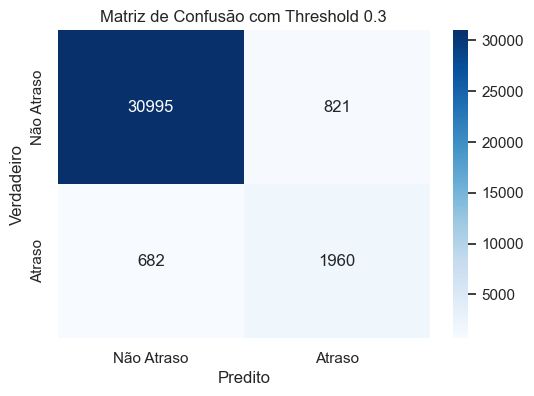

In [80]:
# Dados prontos (como você já fez)
features = ['tempo_entrega', 'order_item_id', 'freight_value', 'price', 'payment_installments', 'review_score']
df_model = orders_full[features + ['atraso']].dropna()

X = df_model[features]
y = df_model['atraso']

# Verificar balanceamento
print("Distribuição das classes no dataset:")
print(y.value_counts(normalize=True))

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar modelo com class_weight='balanced' para tentar corrigir desbalanceamento
modelo = RandomForestClassifier(random_state=42, class_weight='balanced')
modelo.fit(X_train, y_train)

# Previsão padrão (threshold 0.5)
y_pred = modelo.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))

# Calcular AUC-ROC
y_proba = modelo.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

# Ajustar threshold para 0.3 e avaliar de novo (pra tentar captar mais atrasos)
import numpy as np
y_pred_custom = (y_proba > 0.3).astype(int)
print("\nRelatório com threshold customizado (0.3):")
print(classification_report(y_test, y_pred_custom, zero_division=0))

# Matriz de confusão customizada
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Atraso', 'Atraso'], yticklabels=['Não Atraso', 'Atraso'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão com Threshold 0.3')
plt.show()


## 3.3 Segmentação de Clientes

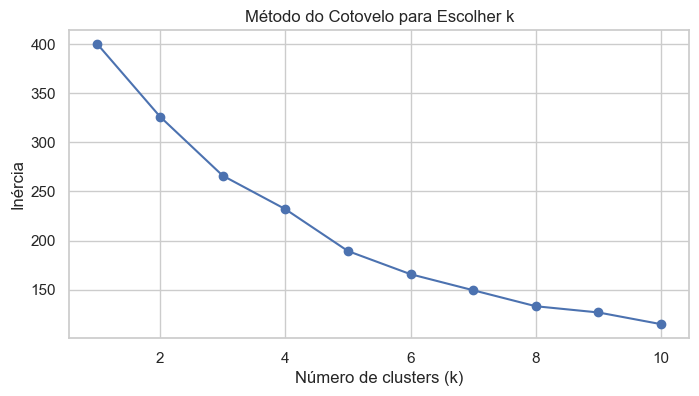

         total_gasto  num_pedidos  satisfacao_media  tempo_medio_entrega
cluster                                                                 
0        2897.928670    38.700000          4.035015             8.206849
1        1960.414232    15.866667          3.266887             7.802656
2        4115.232839    24.280000          2.689628             6.429430


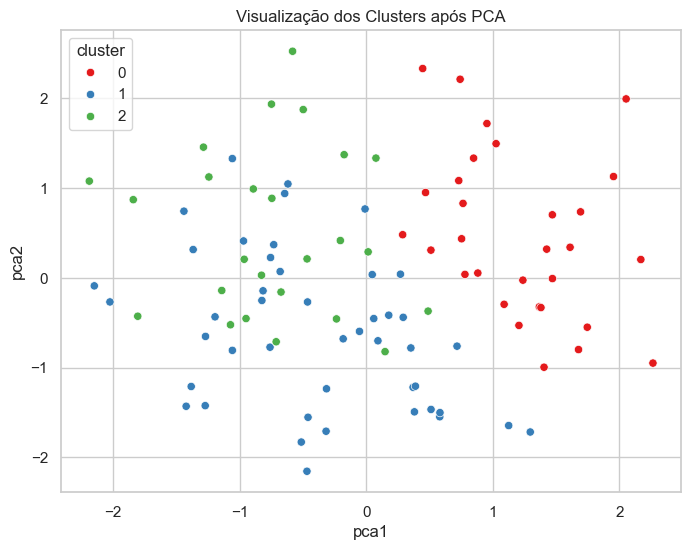

In [69]:
# Suponha que seu DataFrame df_clientes tenha essas colunas:
# 'seller_id' (ou cliente), 'total_gasto', 'num_pedidos', 'satisfacao_media', 'tempo_medio_entrega'

# Exemplo para criar um DataFrame fictício caso não tenha
# (remova essa parte se já tiver seu df_clientes)
df_clientes = pd.DataFrame({
    'seller_id': range(1, 101),
    'total_gasto': np.random.uniform(500, 5000, 100),
    'num_pedidos': np.random.randint(1, 50, 100),
    'satisfacao_media': np.random.uniform(2, 5, 100),
    'tempo_medio_entrega': np.random.uniform(1, 15, 100)
})

# 1. Selecionar features para clustering
features = ['total_gasto', 'num_pedidos', 'satisfacao_media', 'tempo_medio_entrega']
X = df_clientes[features]

# 2. Normalizar os dados (muito importante para clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Encontrar o número ideal de clusters com método do cotovelo
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Escolher k')
plt.show()

# 4. Aplicar K-Means com número escolhido de clusters
k_optimal = 3  # exemplo, escolha após observar o gráfico
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 5. Adicionar a coluna de cluster no DataFrame original
df_clientes['cluster'] = clusters

# 6. Analisar características médias de cada cluster
print(df_clientes.groupby('cluster')[features].mean())

# 7. Visualização simplificada em 2D (usando os dois primeiros componentes principais)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clientes['pca1'] = X_pca[:, 0]
df_clientes['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clientes, x='pca1', y='pca2', hue='cluster', palette='Set1')
plt.title('Visualização dos Clusters após PCA')
plt.show()


### Segmentamos os clientes em três grupos distintos com base no comportamento de compra. O primeiro grupo é formado por clientes frequentes, que gastam bem e estão satisfeitos, ideal para ações de fidelização. O segundo grupo tem clientes com menor frequência e satisfação moderada, que podem ser estimulados a comprar mais com campanhas específicas. O terceiro grupo é composto por clientes que gastam mais, mas estão insatisfeitos, exigindo melhorias no atendimento e experiência. Essas segmentações permitem estratégias de marketing mais direcionadas, aumentando a retenção e o valor dos clientes.

## 3.4 Análise de Satisfação

In [72]:
# Converter para datetime, caso ainda não estejam nesse formato
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date'])
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full['order_purchase_timestamp'])

# Calcular tempo de entrega em dias entre compra e entrega real
orders_full['delivery_time'] = (orders_full['order_delivered_customer_date'] - orders_full['order_purchase_timestamp']).dt.days

# Caso prefira usar a data estimada para comparar, pode criar tempo estimado também:
orders_full['estimated_delivery_time'] = (orders_full['order_estimated_delivery_date'] - orders_full['order_purchase_timestamp']).dt.days

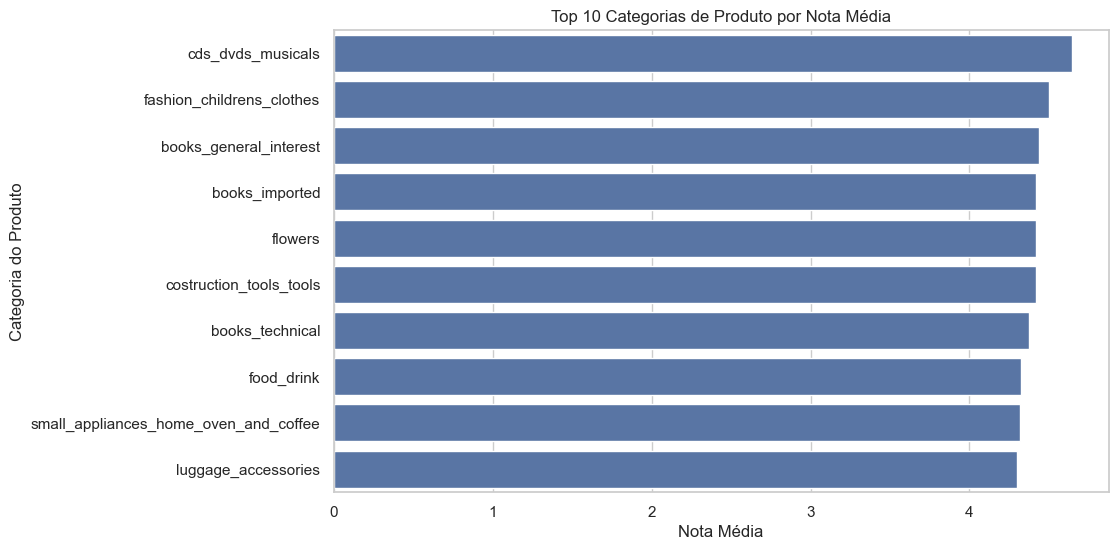

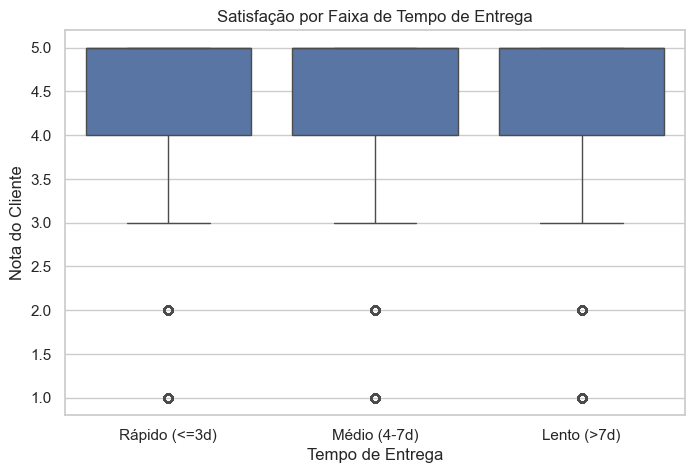

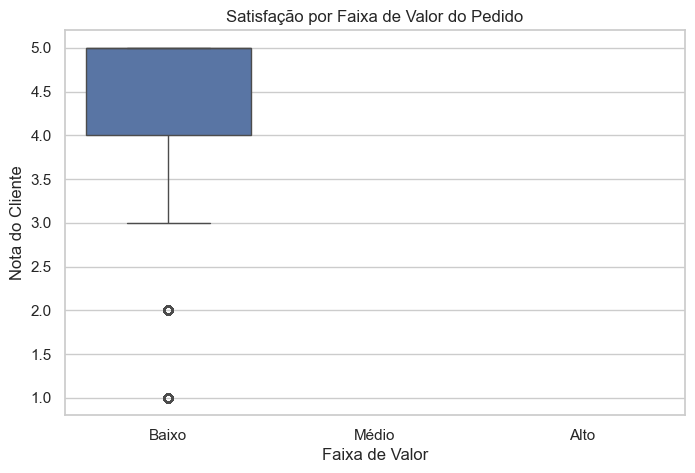

Correlação entre tempo de entrega e satisfação: -0.220 (p=0)
Correlação entre valor do pedido e satisfação: 0.004 (p=0.141)


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# 1. Categorizar tempo de entrega e valor do pedido em faixas
orders_full['tempo_entrega_cat'] = pd.cut(orders_full['delivery_time'],
                                          bins=[-1, 3, 7, 30],
                                          labels=['Rápido (<=3d)', 'Médio (4-7d)', 'Lento (>7d)'])

orders_full['faixa_valor'] = pd.cut(orders_full['price'],
                                    bins=[0, 50, 150, 10000],
                                    labels=['Baixo', 'Médio', 'Alto'])

# 2. Média da satisfação por categoria do produto
cat_satisfacao = orders_full.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=cat_satisfacao.values, y=cat_satisfacao.index)
plt.title('Top 10 Categorias de Produto por Nota Média')
plt.xlabel('Nota Média')
plt.ylabel('Categoria do Produto')
plt.show()

# 3. Boxplot da satisfação por faixa de tempo de entrega
plt.figure(figsize=(8,5))
sns.boxplot(x='tempo_entrega_cat', y='review_score', data=orders_full)
plt.title('Satisfação por Faixa de Tempo de Entrega')
plt.xlabel('Tempo de Entrega')
plt.ylabel('Nota do Cliente')
plt.show()

# 4. Boxplot da satisfação por faixa de valor do pedido
plt.figure(figsize=(8,5))
sns.boxplot(x='faixa_valor', y='review_score', data=orders_full)
plt.title('Satisfação por Faixa de Valor do Pedido')
plt.xlabel('Faixa de Valor')
plt.ylabel('Nota do Cliente')
plt.show()

# 5. Correlação entre variáveis numéricas e satisfação (Spearman para não linear)
corr_tempo, p_val_tempo = spearmanr(orders_full['delivery_time'], orders_full['review_score'], nan_policy='omit')
corr_preco, p_val_preco = spearmanr(orders_full['price'], orders_full['review_score'], nan_policy='omit')

print(f'Correlação entre tempo de entrega e satisfação: {corr_tempo:.3f} (p={p_val_tempo:.3g})')
print(f'Correlação entre valor do pedido e satisfação: {corr_preco:.3f} (p={p_val_preco:.3g})')


### A análise de correlação mostrou que o tempo de entrega possui uma relação negativa significativa com a satisfação do cliente, indicando que entregas mais rápidas tendem a gerar avaliações melhores. Por outro lado, o valor do pedido não apresentou influência significativa sobre a satisfação, sugerindo que clientes não avaliam o serviço com base no preço pago.

# 4. Visualização e Dashboards

### 4.1 Um dashboard geral que mostre a evolução das vendas ao longo do tempo, com filtros por estado e categoria de produto

In [12]:
# Supondo que essas colunas existam em orders_full
estados = sorted(orders_full['customer_state'].dropna().unique())
categorias = sorted(orders_full['product_category_name'].dropna().unique())

seletor_estado = widgets.Dropdown(
    options=['Todos'] + estados,
    description='Estado:',
    value='Todos'
)

seletor_categoria = widgets.Dropdown(
    options=['Todas'] + categorias,
    description='Categoria:',
    value='Todas'
)

In [13]:
def atualizar_dashboard(estado, categoria):
    df_filtrado = orders_full.copy()
    
    if estado != 'Todos':
        df_filtrado = df_filtrado[df_filtrado['customer_state'] == estado]
    
    if categoria != 'Todas':
        df_filtrado = df_filtrado[df_filtrado['product_category_name'] == categoria]
    
    vendas_por_mes = df_filtrado.groupby('order_month')['price'].sum()
    
    plt.figure(figsize=(10,5))
    vendas_por_mes.plot(kind='line', marker='o', color='blue')
    plt.title('Evolução das Vendas ao Longo do Tempo')
    plt.xlabel('Mês')
    plt.ylabel('Faturamento Total (R$)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
ui = widgets.HBox([seletor_estado, seletor_categoria])
out = widgets.interactive_output(atualizar_dashboard, {
    'estado': seletor_estado,
    'categoria': seletor_categoria
})

display(ui, out)


### 4.2 Um mapa de calor mostrando a concentração de vendas por região/estado do Brasil

In [46]:
# Exemplo de geolocalização
mapa = folium.Map(location=[-15.7801, -47.9292], zoom_start=5)  # Centro do Brasil

# Adicionando pontos ao mapa
pontos_vendas = orders_full[['customer_lat', 'customer_lng', 'price']].dropna()

# Garantir que as latitudes e longitudes sejam válidas
heat_data = [[row['customer_lat'], row['customer_lng'], row['price']] for index, row in pontos_vendas.iterrows()]

# Adicionando o HeatMap ao mapa
HeatMap(heat_data).add_to(mapa)

# Salvar o mapa em um arquivo HTML
mapa.save("mapa_vendas.html")
mapa

### 4.3 Um conjunto de gráficos que apresente a relação entre avaliação do cliente e tempo de entrega

In [ ]:
# Calcular o tempo de entrega em dias
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date'])
orders_full['order_approved_at'] = pd.to_datetime(orders_full['order_approved_at'])

# Garantir que a data de entrega e a data de aprovação não sejam nulas
orders_full['tempo_entrega'] = (orders_full['order_delivered_customer_date'] - orders_full['order_approved_at']).dt.days

# Remover valores nulos ou negativos (caso existam)
orders_full = orders_full[orders_full['tempo_entrega'] >= 0]
orders_full = orders_full.dropna(subset=['review_score', 'tempo_entrega'])

# Visualização: Gráfico de dispersão entre avaliação do cliente e tempo de entrega
plt.figure(figsize=(10,6))
sns.scatterplot(data=orders_full, x='review_score', y='tempo_entrega', color='teal', alpha=0.6)
plt.title('Relação entre Avaliação do Cliente e Tempo de Entrega')
plt.xlabel('Avaliação do Cliente')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Definindo as faixas de tempo de entrega
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]  # Faixas de 0 a 60 dias
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60']

# Criando uma nova coluna para as faixas de tempo
orders_full['faixa_tempo_entrega'] = pd.cut(orders_full['tempo_entrega'], bins=bins, labels=labels, right=False)

# Contando o número de avaliações por faixa de tempo de entrega, com observed=False para evitar o aviso
avaliacoes_por_faixa = orders_full.groupby('faixa_tempo_entrega', observed=False)['review_score'].count()

# Criando o gráfico de barras
plt.figure(figsize=(12,6))
avaliacoes_por_faixa.plot(kind='bar', color='skyblue')
plt.title('Número de Avaliações por Faixa de Tempo de Entrega')
plt.xlabel('Faixa de Tempo de Entrega (dias)')
plt.ylabel('Número de Avaliações')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# Agrupar por vendedor (seller_id)
vendedores_df = orders_full.groupby('seller_id').agg({
    'order_id': 'count',                       # volume de vendas (número de pedidos)
    'review_score': 'mean',                    # média das avaliações
    'tempo_entrega': 'mean'                    # tempo médio de entrega
}).rename(columns={
    'order_id': 'volume_vendas',
    'review_score': 'avaliacao_media',
    'tempo_entrega': 'tempo_entrega_medio'
}).reset_index()


In [ ]:
top_vendas = vendedores_df.sort_values('volume_vendas', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_vendas, x='seller_id', y='volume_vendas', hue='seller_id', palette='Greens_r', legend=False)
plt.title('Top 10 Vendedores por Volume de Vendas')
plt.xlabel('ID do Vendedor')
plt.ylabel('Volume de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
top_avaliacao = vendedores_df[vendedores_df['volume_vendas'] >= 20]
top_avaliacao = top_avaliacao.sort_values('avaliacao_media', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_avaliacao, x='seller_id', y='avaliacao_media', hue='seller_id', palette='Blues', legend=False)
plt.title('Top 10 Vendedores por Avaliação Média (mínimo 20 vendas)')
plt.xlabel('ID do Vendedor')
plt.ylabel('Avaliação Média')
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


In [ ]:
top_entrega = vendedores_df[vendedores_df['volume_vendas'] >= 20]
top_entrega = top_entrega.sort_values('tempo_entrega_medio').head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_entrega, x='seller_id', y='tempo_entrega_medio', hue='seller_id', palette='Oranges', legend=False)
plt.title('Top 10 Vendedores com Menor Tempo Médio de Entrega')
plt.xlabel('ID do Vendedor')
plt.ylabel('Tempo Médio de Entrega (dias)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.4 Um dashboard de análise dos vendedores, mostrando quais têm melhor desempenho em termos de volume de vendas, satisfação do cliente e tempo de entrega

In [28]:
# Preparar os dados
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full['order_purchase_timestamp'])
orders_full['order_delivered_customer_date'] = pd.to_datetime(orders_full['order_delivered_customer_date'])
orders_full['delivery_time'] = (orders_full['order_delivered_customer_date'] - orders_full['order_purchase_timestamp']).dt.days

# Métricas por vendedor
seller_stats = orders_full.groupby('seller_id').agg({
    'price': 'sum',
    'review_score': 'mean',
    'delivery_time': 'mean',
    'order_id': 'count'
}).rename(columns={
    'price': 'faturamento_total',
    'review_score': 'satisfacao_media',
    'delivery_time': 'tempo_medio_entrega',
    'order_id': 'qtd_pedidos'
}).reset_index()

# Slider para filtrar por número mínimo de pedidos
slider_pedidos = widgets.IntSlider(value=10, min=1, max=100, step=1, description='Pedidos mín:')

# Função de atualização do gráfico
def atualizar_dashboard(pedidos_min):
    clear_output(wait=True)
    display(slider_pedidos)
    
    df_filtrado = seller_stats[seller_stats['qtd_pedidos'] >= pedidos_min]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Gráfico 1 - Faturamento
    sns.barplot(data=df_filtrado.sort_values('faturamento_total', ascending=False).head(10),
            x='faturamento_total', y='seller_id', hue='seller_id', legend=False, ax=axes[0], palette='Blues_d')
    axes[0].set_title('Top Vendedores por Faturamento')
    axes[0].set_xlabel('Faturamento (R$)')
    axes[0].set_ylabel('')

    # Gráfico 2 - Satisfação
    sns.barplot(data=df_filtrado.sort_values('satisfacao_media', ascending=False).head(10),
            x='satisfacao_media', y='seller_id', hue='seller_id', legend=False, ax=axes[1], palette='Greens_d')
    axes[1].set_title('Top Vendedores por Satisfação')
    axes[1].set_xlabel('Nota Média')
    axes[1].set_ylabel('')

    # Gráfico 3 - Tempo de Entrega
    sns.barplot(data=df_filtrado.sort_values('tempo_medio_entrega').head(10),
            x='tempo_medio_entrega', y='seller_id', hue='seller_id', legend=False, ax=axes[2], palette='Reds_d')
    axes[2].set_title('Vendedores com Entrega Mais Rápida')
    axes[2].set_xlabel('Dias')
    axes[2].set_ylabel('')

    plt.tight_layout()
    plt.show()

# Widget interativo
_ = widgets.interact(atualizar_dashboard, pedidos_min=slider_pedidos)

interactive(children=(IntSlider(value=10, description='Pedidos mín:', min=1), Output()), _dom_classes=('widget…